In [1]:
pip install kaggle

In [2]:
import kagglehub
import os
import shutil

# Убедитесь, что kagglehub установлен: pip install kagglehub
try:
    print("Загружаем датасет через kagglehub...")
    dataset_path = kagglehub.dataset_download("lyhue1991/ccpd-green")
    print(f"Датасет загружен по пути: {dataset_path}")

    # Проверяем содержимое скачанной директории
    print("\nСодержимое скачанной директории:")
    for item in os.listdir(dataset_path):
        print(f" - {item}")

    # Определяем путь к данным (может быть разным в зависимости от структуры датасета)
    possible_data_paths = [
        os.path.join(dataset_path, "CCPD2020"),
        os.path.join(dataset_path, "ccpd_green"),
        dataset_path  # если данные уже в корне
    ]

    # Ищем действительный путь к данным
    DATASET_SOURCE_PATH = None
    for path in possible_data_paths:
        if os.path.exists(path):
            DATASET_SOURCE_PATH = path
            break

    if DATASET_SOURCE_PATH is None:
        # Если не нашли стандартные пути, используем корень
        DATASET_SOURCE_PATH = dataset_path

    # Копируем данные в локальную папку для удобства
    local_dataset_path = "./kaggle_dataset"
    if os.path.exists(local_dataset_path):
        shutil.rmtree(local_dataset_path)

    shutil.copytree(DATASET_SOURCE_PATH, local_dataset_path)
    DATASET_SOURCE_PATH = local_dataset_path

    print(f"\nДанные скопированы в: {DATASET_SOURCE_PATH}")

except Exception as e:
    print(f"\nОшибка при загрузке через kagglehub: {e}")
    DATASET_SOURCE_PATH = None

# Проверяем результат
if DATASET_SOURCE_PATH and os.path.exists(DATASET_SOURCE_PATH):
    print("\nУспешно! Структура датасета:")
    # Выводим структуру первых двух уровней
    for root, dirs, files in os.walk(DATASET_SOURCE_PATH):
        level = root.replace(DATASET_SOURCE_PATH, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1)
        for f in files[:3]:  # показываем только первые 3 файла в каждой папке
            print(f"{subindent}{f}")
        if len(files) > 3:
            print(f"{subindent}... и еще {len(files)-3} файлов")
        if level >= 1:  # ограничиваем глубину вывода
            break
else:
    print("\nНе удалось загрузить датасет")

Загружаем датасет через kagglehub...


100%|██████████| 866M/866M [00:22<00:00, 39.9MB/s]

Extracting files...


Датасет загружен по пути: /root/.cache/kagglehub/datasets/lyhue1991/ccpd-green/versions/1

Содержимое скачанной директории:
 - ccpd_green

Данные скопированы в: ./kaggle_dataset

Успешно! Структура датасета:
kaggle_dataset/
    train/
        0134049479167-90_265-229I398_442I461-442I458_233I461_229I399_436I398-0_0_3_24_33_33_26_29-98-23.jpg
        016321614583333335-93_259-249I407_467I482-452I482_249I472_263I407_467I420-0_0_3_24_33_30_30_30-69-9.jpg
        0161588541667-90_265-258I469_462I549-457I540_258I549_264I469_462I470-0_0_3_24_26_25_24_26-131-148.jpg
        ... и еще 5766 файлов


Начало обработки данных CCPD...
Создание метаданных...
Найдено 5769 изображений


Обработка файлов: 100%|██████████| 5769/5769 [00:00<00:00, 175500.38it/s]


Создано 5769 записей метаданных
Создание YOLO формата...
Размеры изображения: 720x1160
Разделение данных...
Предупреждение: запрошенные размеры превышают количество данных
Train: 4615
Val: 576
Test: 578
Создание структуры папок YOLO...
Копирование изображений и создание меток...
Обработка train...


Копирование train: 100%|██████████| 4615/4615 [00:01<00:00, 2335.91it/s]


Обработка val...


Копирование val: 100%|██████████| 576/576 [00:00<00:00, 2331.85it/s]


Обработка test...


Копирование test: 100%|██████████| 578/578 [00:00<00:00, 2046.43it/s]


Конфигурационный файл создан: ./yolo_dataset/dataset.yaml
Визуализация образцов...


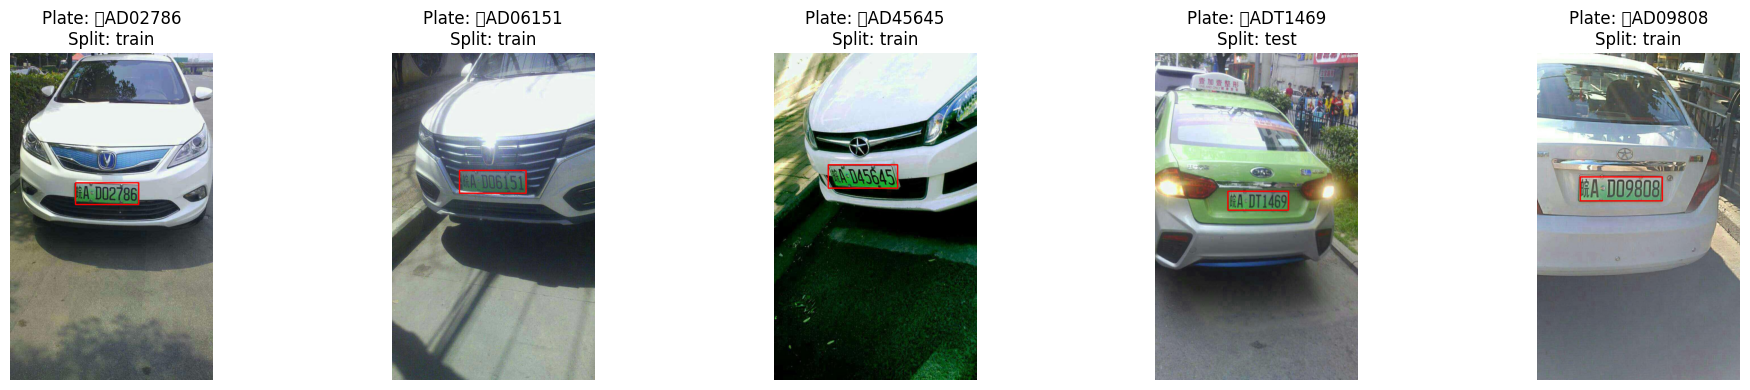

Обработка завершена!
Данные сохранены в: /content/yolo_dataset
Конфигурационный файл: ./yolo_dataset/dataset.yaml

=== СТАТИСТИКА ДАТАСЕТА ===
Общее количество изображений: 5769

Распределение по разделам:
split
train    4615
test      578
val       576
Name: count, dtype: int64

Пример данных:
                                          image_path        sub  x1_bbox  \
0  /content/kaggle_dataset/train/0134049479167-90...  ccpd_base      229   
1  /content/kaggle_dataset/train/0163216145833333...  ccpd_base      249   
2  /content/kaggle_dataset/train/0161588541667-90...  ccpd_base      258   
3  /content/kaggle_dataset/train/0329459635417-90...  ccpd_base      104   
4  /content/kaggle_dataset/train/0102940538194-90...  ccpd_base      302   

   y1_bbox  x2_bbox  y2_bbox plate_number      xmid      ymid  bb_width  \
0      398      442      461     皖AD09925  0.465972  0.370259  0.295833   
1      407      467      482     皖AD09666  0.497222  0.383190  0.302778   
2      469      462   

In [3]:
# Chinese License Plate Recognition - Локальная адаптация для ccpd_base
# Обработка 20,000 изображений из локальной папки

import os
import shutil
import cv2
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
from google.colab import drive
warnings.filterwarnings("ignore")

# Определение символов (как в оригинальном коде)
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']


# Путь к данным в Google Drive
BASE_PATH = "/content/kaggle_dataset/train"  # Измените на ваш путь

# Проверка доступности данных
if not os.path.exists(BASE_PATH):
    raise FileNotFoundError(f"Папка {BASE_PATH} не найдена! Проверьте путь в Google Drive.")

# Определение символов (как в оригинальном коде)

def extract_plate_number(plate_number):
    """Извлечение номера из закодированной строки"""
    chi_let = provinces[int(plate_number.split("_")[0])]
    alp_let = alphabets[int(plate_number.split("_")[1])]
    alp_num_let = plate_number.split("_")[2:]
    alp_num_let = "".join([ads[int(char)] for char in alp_num_let])
    all_let = chi_let + alp_let + alp_num_let
    return all_let

def create_metadata(base_path, max_images=10000):
    """Создание метаданных для изображений из локальной папки"""
    print("Создание метаданных...")

    # Получение списка файлов
    pattern = os.path.join(base_path, "*.jpg")
    all_files = glob.glob(pattern)

    print(f"Найдено {len(all_files)} изображений")

    # Ограничиваем количество файлов
    if len(all_files) > max_images:
        all_files = all_files[:max_images]
        print(f"Используем первые {max_images} изображений")

    # Создание DataFrame
    data = []
    for file_path in tqdm(all_files, desc="Обработка файлов"):
        filename = os.path.basename(file_path)
        detail = filename[:-4]  # убираем .jpg

        try:
            # Парсинг имени файла
            file_parts = detail.split("-")

            # Bounding Box
            bbox = file_parts[2]
            x1_bbox = int(bbox.split("_")[0].split("I")[0])
            y1_bbox = int(bbox.split("_")[0].split("I")[1])
            x2_bbox = int(bbox.split("_")[1].split("I")[0])
            y2_bbox = int(bbox.split("_")[1].split("I")[1])

            # License Plate Number
            plate_number = file_parts[4]
            plate_text = extract_plate_number(plate_number)

            data.append({
                'image_path': file_path,
                'sub': 'ccpd_base',
                'x1_bbox': x1_bbox,
                'y1_bbox': y1_bbox,
                'x2_bbox': x2_bbox,
                'y2_bbox': y2_bbox,
                'plate_number': plate_text
            })
        except Exception as e:
            print(f"Ошибка при обработке файла {filename}: {e}")
            continue

    df_metadata = pd.DataFrame(data)
    print(f"Создано {len(df_metadata)} записей метаданных")
    return df_metadata

def create_yolo_format(df_metadata):
    """Создание YOLOv8 формата bounding box"""
    print("Создание YOLO формата...")

    # Получение размеров изображений (предполагаем стандартные размеры CCPD)
    # Если нужно, можно считать из первого изображения
    sample_img = cv2.imread(df_metadata['image_path'].iloc[0])
    img_height, img_width = sample_img.shape[:2]
    print(f"Размеры изображения: {img_width}x{img_height}")

    # Нормализация координат для YOLO
    df_metadata['xmid'] = (df_metadata['x1_bbox'] + df_metadata['x2_bbox']) / (2 * img_width)
    df_metadata['ymid'] = (df_metadata['y1_bbox'] + df_metadata['y2_bbox']) / (2 * img_height)
    df_metadata['bb_width'] = (df_metadata['x2_bbox'] - df_metadata['x1_bbox']) / img_width
    df_metadata['bb_height'] = (df_metadata['y2_bbox'] - df_metadata['y1_bbox']) / img_height

    return df_metadata

def split_data(df_metadata, train_size=16000, val_size=2000, test_size=2000):
    """Разделение данных на train/val/test"""
    print("Разделение данных...")

    total_size = len(df_metadata)
    if train_size + val_size + test_size > total_size:
        print("Предупреждение: запрошенные размеры превышают количество данных")
        # Пропорциональное масштабирование
        ratio = total_size / (train_size + val_size + test_size)
        train_size = int(train_size * ratio)
        val_size = int(val_size * ratio)
        test_size = total_size - train_size - val_size

    # Создание списка разделения
    split_list = ['train'] * train_size + ['val'] * val_size + ['test'] * test_size

    # Если размер меньше общего количества, дополняем train
    if len(split_list) < total_size:
        split_list.extend(['train'] * (total_size - len(split_list)))

    df_metadata['split'] = split_list[:total_size]

    print(f"Train: {sum(1 for x in split_list if x == 'train')}")
    print(f"Val: {sum(1 for x in split_list if x == 'val')}")
    print(f"Test: {sum(1 for x in split_list if x == 'test')}")

    return df_metadata

def create_yolo_dataset_structure(output_dir="./yolo_dataset"):
    """Создание структуры папок для YOLO"""
    print("Создание структуры папок YOLO...")

    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(output_dir, split)
        os.makedirs(split_dir, exist_ok=True)

    return output_dir

def copy_images_and_create_labels(df_metadata, output_dir):
    """Копирование изображений и создание файлов меток"""
    print("Копирование изображений и создание меток...")

    for split in ['train', 'val', 'test']:
        print(f"Обработка {split}...")
        df_split = df_metadata[df_metadata['split'] == split].reset_index(drop=True)
        split_dir = os.path.join(output_dir, split)

        for idx, row in tqdm(df_split.iterrows(), total=len(df_split), desc=f"Копирование {split}"):
            # Копирование изображения
            src_path = row['image_path']
            img_name = os.path.basename(src_path)
            dst_img_path = os.path.join(split_dir, img_name)
            shutil.copy2(src_path, dst_img_path)

            # Создание файла меток
            txt_name = os.path.splitext(img_name)[0] + '.txt'
            dst_txt_path = os.path.join(split_dir, txt_name)

            # YOLO формат: class_id x_center y_center width height
            label_line = f"0 {row['xmid']:.6f} {row['ymid']:.6f} {row['bb_width']:.6f} {row['bb_height']:.6f}"

            with open(dst_txt_path, 'w') as f:
                f.write(label_line)

def create_yaml_config(output_dir):
    """Создание конфигурационного файла для YOLO"""
    yaml_content = f"""# CCPD Dataset Configuration
train: {os.path.abspath(os.path.join(output_dir, 'train'))}
val: {os.path.abspath(os.path.join(output_dir, 'val'))}
test: {os.path.abspath(os.path.join(output_dir, 'test'))}

nc: 1

names: ['license_plate']
"""

    yaml_path = os.path.join(output_dir, 'dataset.yaml')
    with open(yaml_path, 'w', encoding='utf-8') as f:
        f.write(yaml_content)

    print(f"Конфигурационный файл создан: {yaml_path}")
    return yaml_path

def visualize_samples(df_metadata, num_samples=5):
    """Визуализация образцов данных"""
    print("Визуализация образцов...")

    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    if num_samples == 1:
        axes = [axes]

    sample_indices = np.random.choice(len(df_metadata), num_samples, replace=False)

    for i, idx in enumerate(sample_indices):
        row = df_metadata.iloc[idx]

        # Загрузка изображения
        img = cv2.imread(row['image_path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Рисование bounding box
        x1, y1, x2, y2 = row['x1_bbox'], row['y1_bbox'], row['x2_bbox'], row['y2_bbox']
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 3)

        axes[i].imshow(img)
        axes[i].set_title(f"Plate: {row['plate_number']}\nSplit: {row['split']}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def main():
    """Основная функция"""
    print("Начало обработки данных CCPD...")

    # Проверка существования папки
    if not os.path.exists(BASE_PATH):
        print(f"Ошибка: Папка {BASE_PATH} не найдена!")
        return None

    # 1. Создание метаданных
    df_metadata = create_metadata(BASE_PATH, max_images=20000)

    if df_metadata.empty:
        print("Ошибка: Не удалось создать метаданные!")
        return None

    # 2. Создание YOLO формата
    df_metadata = create_yolo_format(df_metadata)

    # 3. Разделение данных
    df_metadata = split_data(df_metadata)

    # 4. Создание структуры папок
    output_dir = create_yolo_dataset_structure()

    # 5. Копирование изображений и создание меток
    copy_images_and_create_labels(df_metadata, output_dir)

    # 6. Создание конфигурационного файла
    yaml_path = create_yaml_config(output_dir)

    # 7. Визуализация образцов
    visualize_samples(df_metadata)

    print("Обработка завершена!")
    print(f"Данные сохранены в: {os.path.abspath(output_dir)}")
    print(f"Конфигурационный файл: {yaml_path}")

    return df_metadata, output_dir

# Запуск обработки
if __name__ == "__main__":
    df_result, dataset_dir = main()

    # Показ статистики
    if df_result is not None:
        print("\n=== СТАТИСТИКА ДАТАСЕТА ===")
        print(f"Общее количество изображений: {len(df_result)}")
        print("\nРаспределение по разделам:")
        print(df_result['split'].value_counts())
        print("\nПример данных:")
        print(df_result.head())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

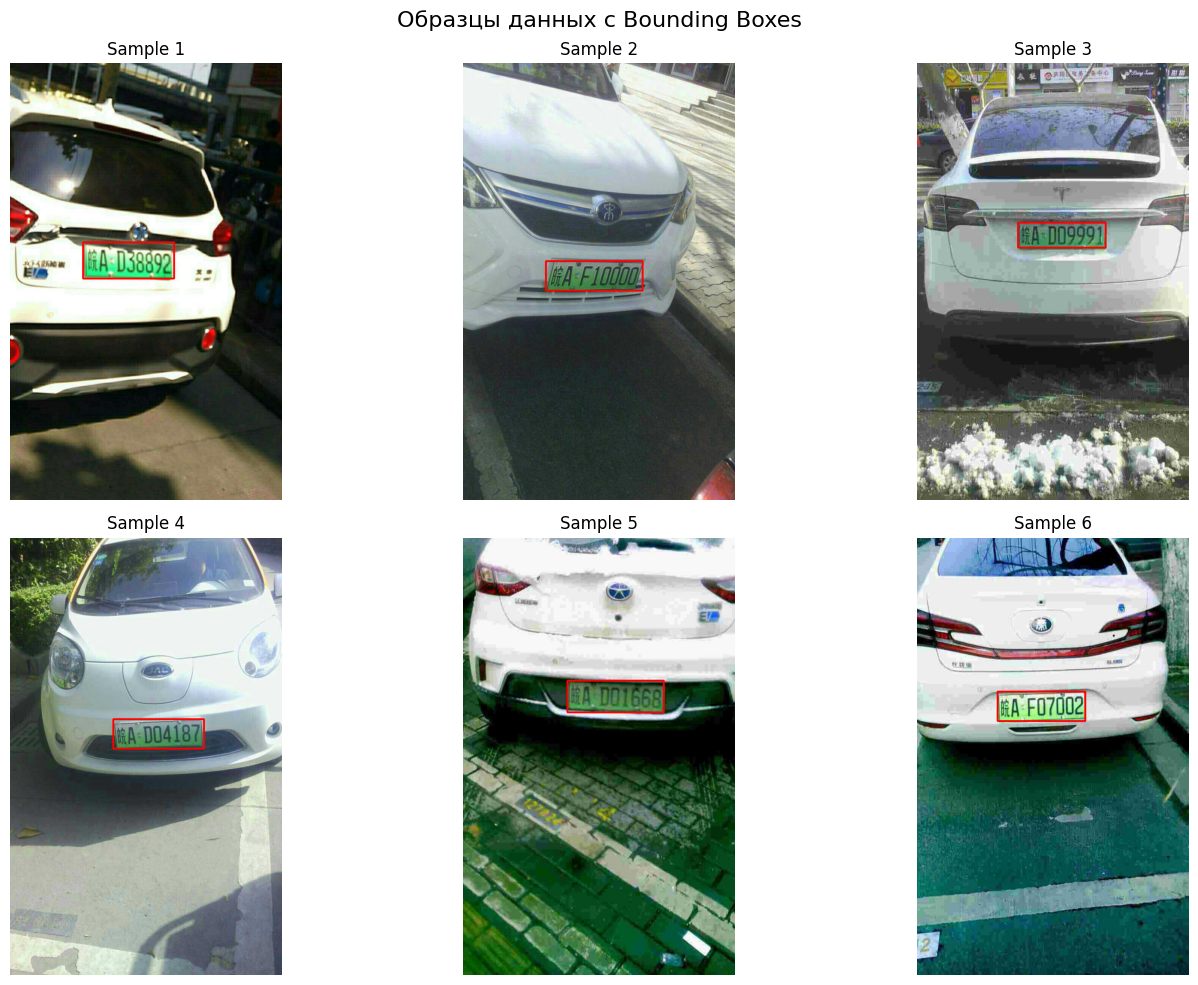


=== ОБУЧЕНИЕ YOLOv8 МОДЕЛИ ===


100%|██████████| 21.5M/21.5M [00:00<00:00, 331MB/s]


YOLOv8s модель загружена
Начинаем обучение на 25 эпох...
Ultralytics 8.3.157 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=license_plate_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_m

100%|██████████| 755k/755k [00:00<00:00, 35.9MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

 22        [15, 18, 21]  1   2116435  ultralytics.nn.modules.head.Detect           [1, [128, 256, 512]]          
Model summary: 129 layers, 11,135,987 parameters, 11,135,971 gradients, 28.6 GFLOPs

Transferred 349/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 151MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 35.1±10.3 MB/s, size: 78.8 KB)


train: Scanning /content/yolo_dataset/train... 4615 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4615/4615 [00:10<00:00, 437.21it/s]


train: New cache created: /content/yolo_dataset/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 18.1±12.3 MB/s, size: 72.0 KB)


val: Scanning /content/yolo_dataset/val... 576 images, 0 backgrounds, 0 corrupt: 100%|██████████| 576/576 [00:01<00:00, 374.81it/s]


val: New cache created: /content/yolo_dataset/val.cache
Plotting labels to runs/license_plate_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/license_plate_detection
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.69G     0.6992     0.7998     0.8981         20        640: 100%|██████████| 289/289 [01:56<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.51it/s]

                   all        576        576          1      0.999      0.995       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      3.92G     0.6754     0.4329     0.8859         19        640: 100%|██████████| 289/289 [01:47<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.18it/s]

                   all        576        576      0.995      0.995      0.995      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      3.96G      0.657     0.4058     0.8802         11        640: 100%|██████████| 289/289 [01:42<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.72it/s]

                   all        576        576      0.997      0.995      0.995      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25         4G     0.6409     0.3911     0.8771         19        640: 100%|██████████| 289/289 [01:42<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.67it/s]

                   all        576        576      0.996          1      0.995      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      4.04G     0.6116     0.3639     0.8653         11        640: 100%|██████████| 289/289 [01:46<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.40it/s]

                   all        576        576      0.998          1      0.995      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      4.07G     0.5972     0.3451     0.8653         17        640: 100%|██████████| 289/289 [01:41<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.19it/s]

                   all        576        576      0.998      0.998      0.995       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      4.11G      0.591     0.3446     0.8627         15        640: 100%|██████████| 289/289 [01:42<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.34it/s]

                   all        576        576      0.995      0.998      0.995      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      4.15G      0.576      0.331       0.86         13        640: 100%|██████████| 289/289 [01:42<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.91it/s]

                   all        576        576      0.998          1      0.995      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      4.18G     0.5614     0.3161     0.8521         13        640: 100%|██████████| 289/289 [01:42<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.73it/s]

                   all        576        576      0.999          1      0.995      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      4.21G      0.567     0.3182     0.8573          8        640: 100%|██████████| 289/289 [01:42<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.75it/s]

                   all        576        576          1          1      0.995      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      4.26G     0.5467     0.3006     0.8507         18        640: 100%|██████████| 289/289 [01:44<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.30it/s]

                   all        576        576      0.998          1      0.995      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      4.29G     0.5476     0.2985     0.8519         17        640: 100%|██████████| 289/289 [01:43<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.23it/s]

                   all        576        576      0.998          1      0.995        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      4.33G     0.5418      0.292     0.8485         15        640: 100%|██████████| 289/289 [01:43<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.26it/s]

                   all        576        576          1          1      0.995      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      4.36G     0.5306     0.2852      0.847         11        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.67it/s]

                   all        576        576          1          1      0.995      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25       4.4G     0.5257     0.2768     0.8451         17        640: 100%|██████████| 289/289 [01:42<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.65it/s]

                   all        576        576          1          1      0.995      0.909


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      4.43G     0.5195     0.2604     0.8362          7        640: 100%|██████████| 289/289 [01:41<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.88it/s]

                   all        576        576          1          1      0.995      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      4.47G     0.5048     0.2508     0.8324          7        640: 100%|██████████| 289/289 [01:39<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.83it/s]

                   all        576        576          1          1      0.995      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25       4.5G     0.5057     0.2474     0.8327          7        640: 100%|██████████| 289/289 [01:40<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.65it/s]

                   all        576        576          1          1      0.995      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      4.54G     0.4978     0.2415     0.8265          7        640: 100%|██████████| 289/289 [01:38<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.74it/s]

                   all        576        576          1          1      0.995      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      4.61G     0.4869     0.2324     0.8287          7        640: 100%|██████████| 289/289 [01:38<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.98it/s]

                   all        576        576      0.998          1      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      4.65G     0.4838     0.2327      0.825          7        640: 100%|██████████| 289/289 [01:38<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.39it/s]

                   all        576        576          1          1      0.995      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      4.71G     0.4765     0.2246      0.822          7        640: 100%|██████████| 289/289 [01:40<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.32it/s]

                   all        576        576          1          1      0.995      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      4.82G     0.4679      0.213     0.8187          7        640: 100%|██████████| 289/289 [01:39<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.34it/s]

                   all        576        576          1          1      0.995      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      4.86G     0.4607     0.2064     0.8172          7        640: 100%|██████████| 289/289 [01:38<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.79it/s]

                   all        576        576          1          1      0.995      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      4.93G      0.454     0.1997     0.8132          7        640: 100%|██████████| 289/289 [01:40<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.75it/s]

                   all        576        576          1          1      0.995      0.919



25 epochs completed in 0.759 hours.
Optimizer stripped from runs/license_plate_detection/weights/last.pt, 22.5MB
Optimizer stripped from runs/license_plate_detection/weights/best.pt, 22.5MB

Validating runs/license_plate_detection/weights/best.pt...
Ultralytics 8.3.157 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.32it/s]


                   all        576        576          1          1      0.995      0.919
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/license_plate_detection
Обучение завершено!

=== АНАЛИЗ РЕЗУЛЬТАТОВ ОБУЧЕНИЯ ===
Результаты обучения:
    epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
20     21  2305.15         0.48382         0.23270         0.82495   
21     22  2411.45         0.47646         0.22463         0.82204   
22     23  2516.71         0.46787         0.21300         0.81870   
23     24  2622.76         0.46068         0.20643         0.81717   
24     25  2730.21         0.45395         0.19975         0.81323   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
20               0.99988                1.0             0.995   
21               0.99989                1.0             0.995   
22               0.99989                1.0             0.995   
23               0.99987

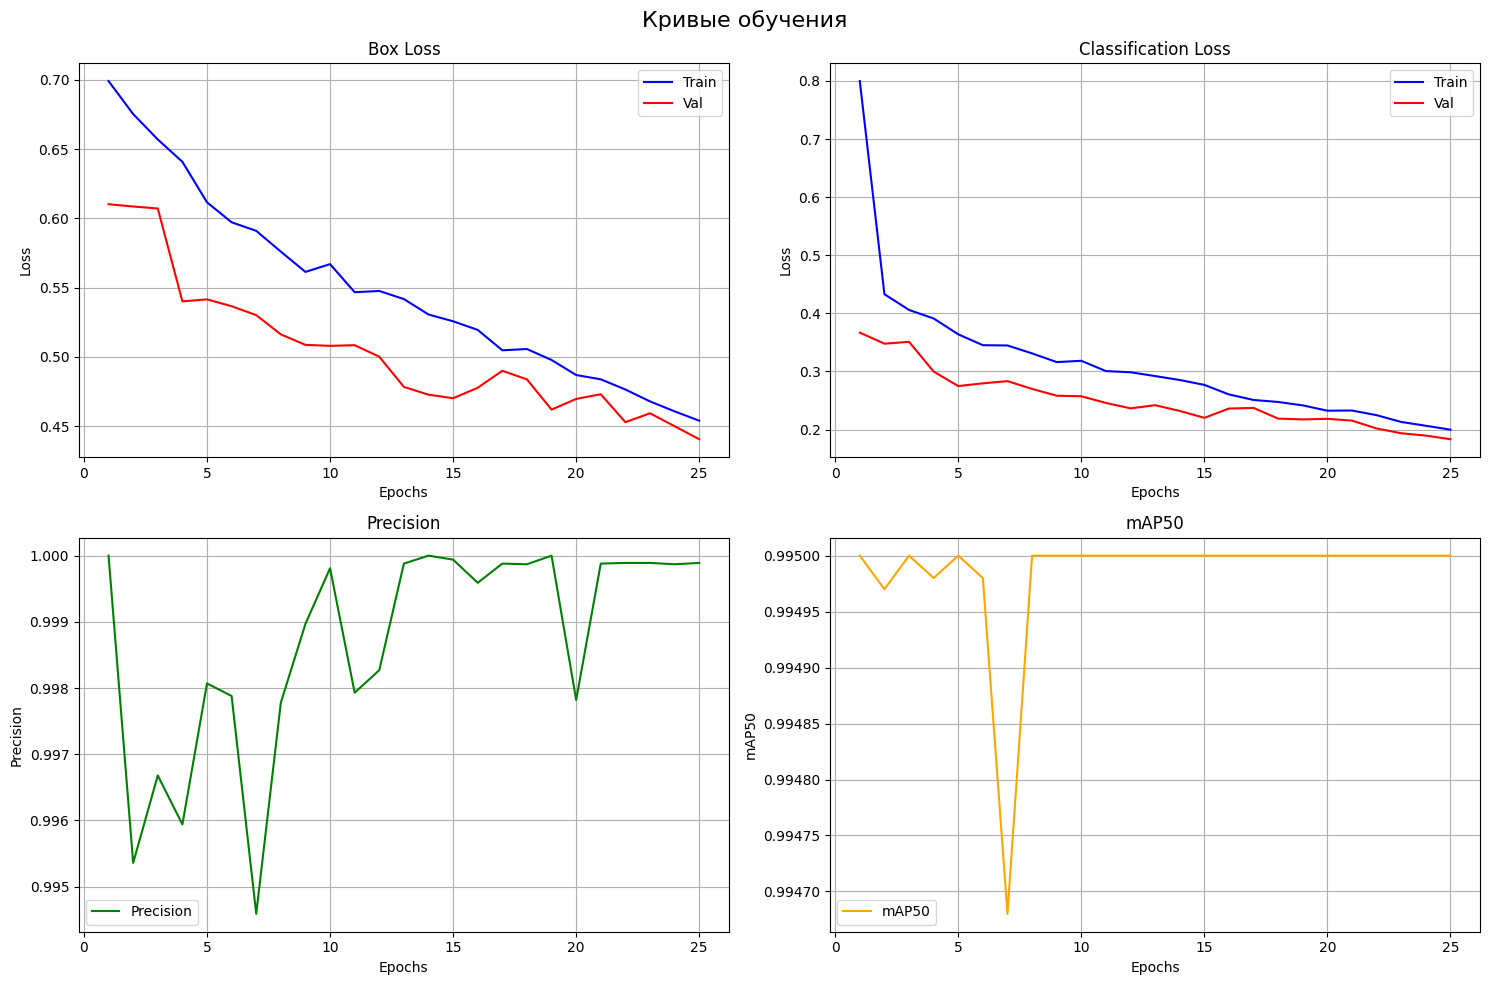


=== ОБУЧЕНИЕ И ТЕСТИРОВАНИЕ ЗАВЕРШЕНО ===
Результаты сохранены в папке './runs/license_plate_detection'


In [4]:
# Chinese License Plate Recognition - YOLOv8 Training
# Адаптированная версия для работы с локальными данными

import os
import gc
import shutil
import time
import random
import cv2
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings("ignore")
%pip install ultralytics
# Импорт для YOLO
try:
    from ultralytics import YOLO
    from ultralytics.utils.plotting import Annotator
    print("Ultralytics импортирован успешно")
except ImportError:
    print("Устанавливаем ultralytics...")
    os.system("pip install ultralytics")
    from ultralytics import YOLO
    from ultralytics.utils.plotting import Annotator

# Настройки путей
DATASET_PATH = "./yolo_dataset"  # Путь к созданному датасету из первого кода
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
VAL_PATH = os.path.join(DATASET_PATH, "val")
TEST_PATH = os.path.join(DATASET_PATH, "test")
CONFIG_PATH = os.path.join(DATASET_PATH, "dataset.yaml")

# Определение символов (как в оригинальном коде)
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

def check_dataset_structure():
    """Проверка структуры датасета"""
    print("=== ПРОВЕРКА СТРУКТУРЫ ДАТАСЕТА ===")

    if not os.path.exists(DATASET_PATH):
        print(f"Ошибка: Датасет не найден по пути {DATASET_PATH}")
        print("Сначала запустите первый код для создания датасета!")
        return False

    required_paths = [TRAIN_PATH, VAL_PATH, TEST_PATH, CONFIG_PATH]
    for path in required_paths:
        if not os.path.exists(path):
            print(f"Ошибка: Не найден {path}")
            return False

    # Подсчет файлов
    train_images = len([f for f in os.listdir(TRAIN_PATH) if f.endswith('.jpg')])
    val_images = len([f for f in os.listdir(VAL_PATH) if f.endswith('.jpg')])
    test_images = len([f for f in os.listdir(TEST_PATH) if f.endswith('.jpg')])

    print(f"Train изображений: {train_images}")
    print(f"Val изображений: {val_images}")
    print(f"Test изображений: {test_images}")
    print(f"Общий размер датасета: {train_images + val_images + test_images}")

    return True

def visualize_sample_data(num_samples=6):
    """Визуализация образцов данных с bounding boxes"""
    print("\n=== ВИЗУАЛИЗАЦИЯ ОБРАЗЦОВ ДАННЫХ ===")

    # Получение случайных изображений из train
    train_images = [f for f in os.listdir(TRAIN_PATH) if f.endswith('.jpg')]
    sample_images = random.sample(train_images, min(num_samples, len(train_images)))

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, img_name in enumerate(sample_images):
        # Загрузка изображения
        img_path = os.path.join(TRAIN_PATH, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Загрузка меток
        txt_name = img_name.replace('.jpg', '.txt')
        txt_path = os.path.join(TRAIN_PATH, txt_name)

        if os.path.exists(txt_path):
            with open(txt_path, 'r') as f:
                line = f.readline().strip()

            # Парсинг YOLO формата
            parts = line.split()
            if len(parts) == 5:
                class_id, x_center, y_center, width, height = map(float, parts)

                # Преобразование в координаты пикселей
                img_h, img_w = image.shape[:2]
                x1 = int((x_center - width/2) * img_w)
                y1 = int((y_center - height/2) * img_h)
                x2 = int((x_center + width/2) * img_w)
                y2 = int((y_center + height/2) * img_h)

                # Рисование bounding box
                cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 3)

        axes[i].imshow(image)
        axes[i].set_title(f"Sample {i+1}")
        axes[i].axis('off')

    plt.suptitle("Образцы данных с Bounding Boxes", fontsize=16)
    plt.tight_layout()
    plt.show()

def train_yolo_model(epochs=10, batch_size=16, img_size=640):
    """Обучение YOLOv8 модели"""
    print("\n=== ОБУЧЕНИЕ YOLOv8 МОДЕЛИ ===")

    # Создание папки для результатов
    results_dir = "./runs"
    os.makedirs(results_dir, exist_ok=True)

    try:
        # Загрузка предобученной модели
        model = YOLO('yolov8s.pt')
        print("YOLOv8s модель загружена")

        # Обучение
        print(f"Начинаем обучение на {epochs} эпох...")
        results = model.train(
            data=CONFIG_PATH,
            epochs=epochs,
            batch=batch_size,
            imgsz=img_size,
            verbose=True,
            project=results_dir,
            name='license_plate_detection',
            save=True,
            plots=True
        )

        print("Обучение завершено!")
        return model, results

    except Exception as e:
        print(f"Ошибка при обучении: {e}")
        return None, None

def analyze_training_results():
    """Анализ результатов обучения"""
    print("\n=== АНАЛИЗ РЕЗУЛЬТАТОВ ОБУЧЕНИЯ ===")

    results_path = "./runs/license_plate_detection"

    if not os.path.exists(results_path):
        print("Результаты обучения не найдены!")
        return

    # Поиск файла результатов
    results_file = None
    for file in os.listdir(results_path):
        if file == "results.csv":
            results_file = os.path.join(results_path, file)
            break

    if results_file and os.path.exists(results_file):
        # Загрузка результатов
        df_results = pd.read_csv(results_file)
        df_results.columns = [col.strip() for col in df_results.columns]

        print("Результаты обучения:")
        print(df_results.tail())

        # Визуализация кривых обучения
        plot_training_curves(df_results)
    else:
        print("Файл results.csv не найден")

def plot_training_curves(df_results):
    """Построение кривых обучения"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss curves
    epochs = range(1, len(df_results) + 1)

    # Box Loss
    if 'train/box_loss' in df_results.columns:
        axes[0, 0].plot(epochs, df_results['train/box_loss'], label='Train', color='blue')
        axes[0, 0].plot(epochs, df_results['val/box_loss'], label='Val', color='red')
        axes[0, 0].set_title('Box Loss')
        axes[0, 0].set_xlabel('Epochs')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

    # Classification Loss
    if 'train/cls_loss' in df_results.columns:
        axes[0, 1].plot(epochs, df_results['train/cls_loss'], label='Train', color='blue')
        axes[0, 1].plot(epochs, df_results['val/cls_loss'], label='Val', color='red')
        axes[0, 1].set_title('Classification Loss')
        axes[0, 1].set_xlabel('Epochs')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

    # Precision
    if 'metrics/precision(B)' in df_results.columns:
        axes[1, 0].plot(epochs, df_results['metrics/precision(B)'], label='Precision', color='green')
        axes[1, 0].set_title('Precision')
        axes[1, 0].set_xlabel('Epochs')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

    # mAP50
    if 'metrics/mAP50(B)' in df_results.columns:
        axes[1, 1].plot(epochs, df_results['metrics/mAP50(B)'], label='mAP50', color='orange')
        axes[1, 1].set_title('mAP50')
        axes[1, 1].set_xlabel('Epochs')
        axes[1, 1].set_ylabel('mAP50')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

    plt.suptitle('Кривые обучения', fontsize=16)
    plt.tight_layout()
    plt.show()

def test_model():
    """Тестирование обученной модели"""
    print("\n=== ТЕСТИРОВАНИЕ МОДЕЛИ ===")

    # Поиск лучшей модели
    best_model_path = "./runs/license_plate_detection/weights/best.pt"

    if not os.path.exists(best_model_path):
        print("Обученная модель не найдена!")
        return None

    # Загрузка модели
    model = YOLO(best_model_path)
    print("Модель загружена для тестирования")

    # Валидация на тестовых данных
    print("Запускаем валидацию на тестовых данных...")
    results = model.val(data=CONFIG_PATH, split='test')

    return model, results

def visualize_predictions(num_samples=6):
    """Визуализация предсказаний модели"""
    print("\n=== ВИЗУАЛИЗАЦИЯ ПРЕДСКАЗАНИЙ ===")

    # Загрузка модели
    best_model_path = "./runs/license_plate_detection/weights/best.pt"

    if not os.path.exists(best_model_path):
        print("Обученная модель не найдена!")
        return

    model = YOLO(best_model_path)

    # Получение случайных тестовых изображений
    test_images = [f for f in os.listdir(TEST_PATH) if f.endswith('.jpg')]
    sample_images = random.sample(test_images, min(num_samples, len(test_images)))

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(TEST_PATH, img_name)

        # Предсказание
        results = model.predict(img_path, verbose=False)

        # Загрузка изображения
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Аннотация предсказаний
        if results and len(results) > 0:
            boxes = results[0].boxes
            if boxes is not None:
                annotator = Annotator(image.copy())
                for box in boxes:
                    if box.conf > 0.5:  # Порог уверенности
                        coords = box.xyxy[0].cpu().numpy().astype(int)
                        conf = float(box.conf)
                        label = f"License Plate {conf:.2f}"
                        annotator.box_label(coords, label, color=(30, 240, 100))

                image = annotator.result()

        axes[i].imshow(image)
        axes[i].set_title(f"Test Sample {i+1}")
        axes[i].axis('off')

    plt.suptitle('Предсказания модели на тестовых данных', fontsize=16)
    plt.tight_layout()
    plt.show()

def evaluate_detailed_predictions():
    """Детальная оценка предсказаний"""
    print("\n=== ДЕТАЛЬНАЯ ОЦЕНКА ПРЕДСКАЗАНИЙ ===")

    # Загрузка модели
    best_model_path = "./runs/license_plate_detection/weights/best.pt"

    if not os.path.exists(best_model_path):
        print("Обученная модель не найдена!")
        return

    model = YOLO(best_model_path)

    # Получение всех тестовых изображений
    test_images = [f for f in os.listdir(TEST_PATH) if f.endswith('.jpg')]

    predictions_data = []

    print("Анализируем предсказания...")
    for img_name in tqdm(test_images[:50]):  # Анализируем первые 50 изображений
        img_path = os.path.join(TEST_PATH, img_name)

        # Предсказание
        results = model.predict(img_path, verbose=False)

        detections = []
        confidences = []

        if results and len(results) > 0:
            boxes = results[0].boxes
            if boxes is not None:
                for box in boxes:
                    if box.conf > 0.3:  # Низкий порог для анализа
                        coords = box.xyxy[0].cpu().numpy().astype(int)
                        conf = float(box.conf)
                        detections.append(coords.tolist())
                        confidences.append(conf)

        predictions_data.append({
            'image_name': img_name,
            'detections': detections,
            'confidences': confidences,
            'num_detections': len(detections)
        })

    # Анализ результатов
    df_pred = pd.DataFrame(predictions_data)

    print("\n=== СТАТИСТИКА ПРЕДСКАЗАНИЙ ===")
    print(f"Общее количество проанализированных изображений: {len(df_pred)}")
    print(f"Изображения с обнаружениями: {len(df_pred[df_pred['num_detections'] > 0])}")
    print(f"Изображения без обнаружений: {len(df_pred[df_pred['num_detections'] == 0])}")

    # Распределение количества обнаружений
    detection_counts = df_pred['num_detections'].value_counts().sort_index()
    print("\nРаспределение количества обнаружений:")
    for count, freq in detection_counts.items():
        print(f"  {count} обнаружений: {freq} изображений")

    # Средняя уверенность
    all_confidences = []
    for confs in df_pred['confidences']:
        all_confidences.extend(confs)

    if all_confidences:
        print(f"\nСредняя уверенность: {np.mean(all_confidences):.3f}")
        print(f"Минимальная уверенность: {np.min(all_confidences):.3f}")
        print(f"Максимальная уверенность: {np.max(all_confidences):.3f}")

def main():
    """Основная функция"""
    print("=== CHINESE LICENSE PLATE RECOGNITION - YOLOv8 TRAINING ===")

    # 1. Проверка структуры датасета
    if not check_dataset_structure():
        return

    # 2. Визуализация образцов данных
    visualize_sample_data()

    # 3. Обучение модели
    model, results = train_yolo_model(epochs=25, batch_size=16)

    if model is None:
        print("Обучение не удалось!")
        return

    # 4. Анализ результатов обучения
    analyze_training_results()

    print("\n=== ОБУЧЕНИЕ И ТЕСТИРОВАНИЕ ЗАВЕРШЕНО ===")
    print("Результаты сохранены в папке './runs/license_plate_detection'")

if __name__ == "__main__":
    main()

In [5]:
test_model, test_results = test_model()


=== ТЕСТИРОВАНИЕ МОДЕЛИ ===
Модель загружена для тестирования
Запускаем валидацию на тестовых данных...
Ultralytics 8.3.157 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 31.4±5.7 MB/s, size: 79.3 KB)


val: Scanning /content/yolo_dataset/test... 578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 578/578 [00:01<00:00, 435.00it/s]


val: New cache created: /content/yolo_dataset/test.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:08<00:00,  4.42it/s]


                   all        578        578          1          1      0.995      0.918
Speed: 0.5ms preprocess, 5.8ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/val



=== ВИЗУАЛИЗАЦИЯ ПРЕДСКАЗАНИЙ ===


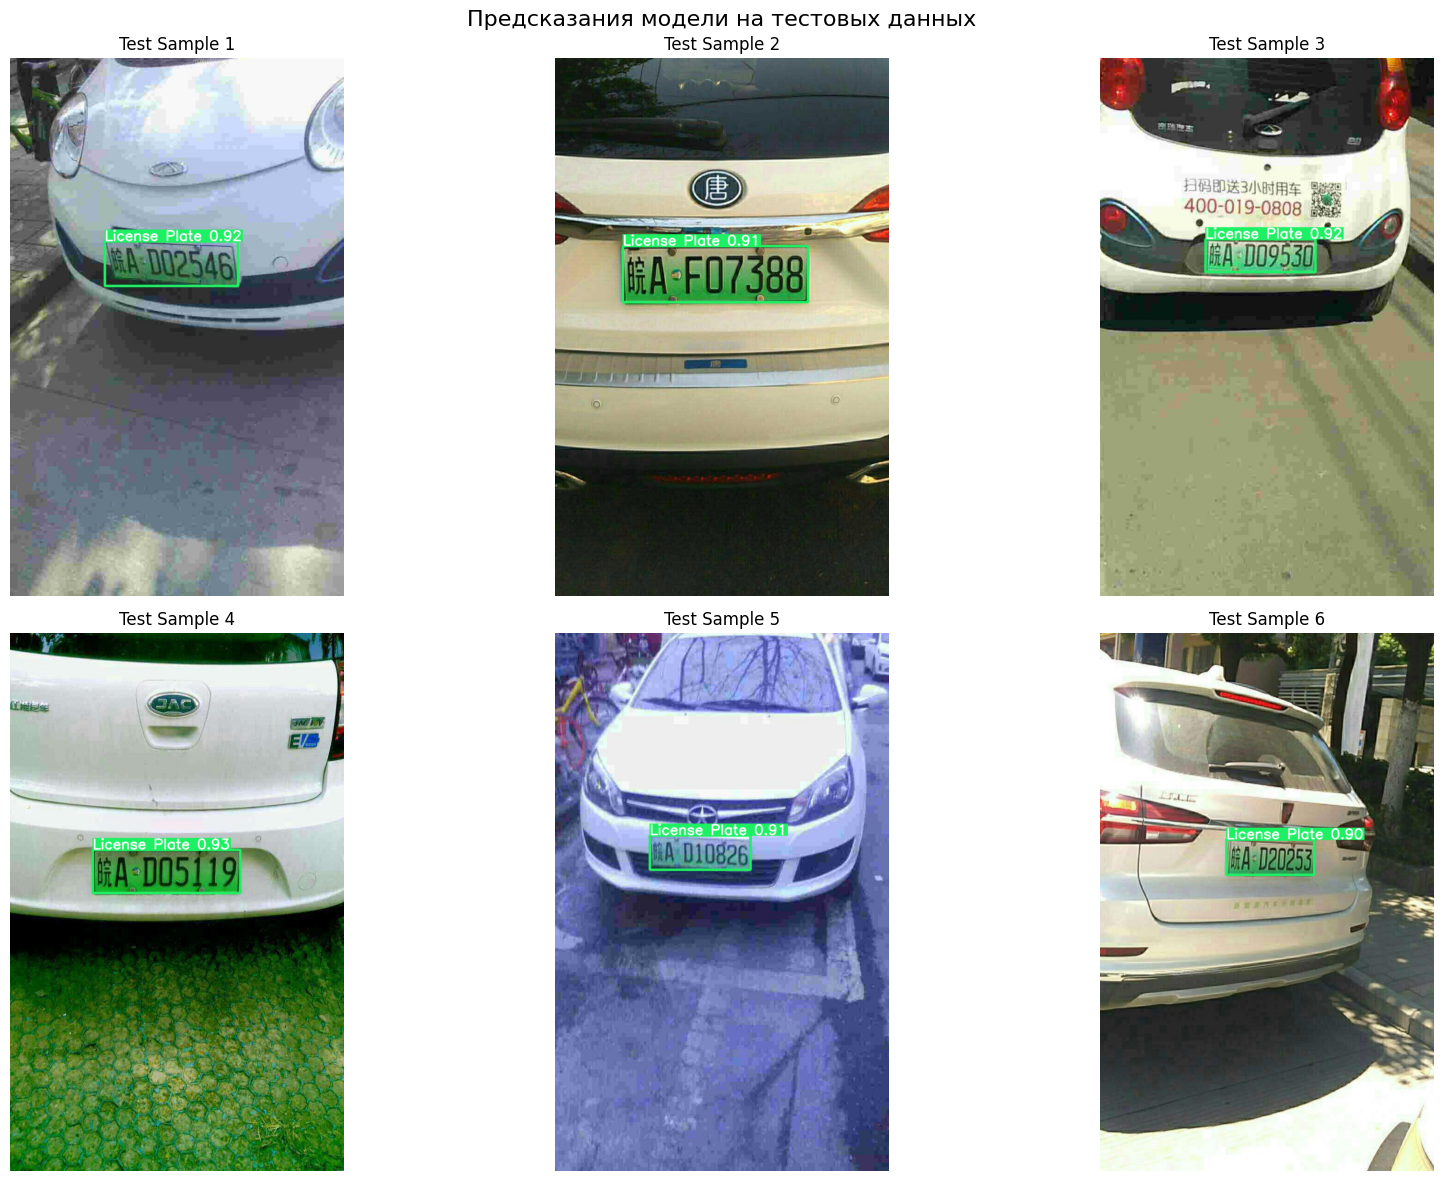

In [6]:
visualize_predictions()

In [7]:
evaluate_detailed_predictions()


=== ДЕТАЛЬНАЯ ОЦЕНКА ПРЕДСКАЗАНИЙ ===
Анализируем предсказания...


100%|██████████| 50/50 [00:01<00:00, 46.73it/s]


=== СТАТИСТИКА ПРЕДСКАЗАНИЙ ===
Общее количество проанализированных изображений: 50
Изображения с обнаружениями: 50
Изображения без обнаружений: 0

Распределение количества обнаружений:
  1 обнаружений: 50 изображений

Средняя уверенность: 0.910
Минимальная уверенность: 0.872
Максимальная уверенность: 0.925


In [8]:
!pip install easyocr
!pip install paddleocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 22.5 MB/s eta 0:00:00


In [7]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import random
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import editdistance
import string
from collections import Counter
import math
warnings.filterwarnings("ignore")

# ==== Константы ====
PROVINCES = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
LETTERS = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
DIGITS = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Создаем полный словарь символов для CTC
CHARS = PROVINCES + LETTERS + DIGITS
CHAR_DICT = {char: i for i, char in enumerate(CHARS)}
CHAR_DICT['<BLANK>'] = len(CHARS)  # CTC blank token
DICT_CHAR = {i: char for char, i in CHAR_DICT.items()}

# ==== Базовый анализ ====
def calculate_baseline_accuracy(ground_truths):
    """Вычисляет baseline accuracy - качество при всегда предсказании самого частого символа для каждой позиции"""
    position_stats = [Counter() for _ in range(8)]

    # Собираем статистику по позициям
    for text in ground_truths:
        for i, char in enumerate(text):
            if i < 8:
                position_stats[i][char] += 1

    # Находим самые частые символы для каждой позиции
    most_common_chars = []
    for i in range(8):
        if position_stats[i]:
            most_common_char = position_stats[i].most_common(1)[0][0]
            most_common_chars.append(most_common_char)
        else:
            most_common_chars.append('0')  # fallback

    # Вычисляем baseline accuracy
    baseline_predictions = [''.join(most_common_chars)] * len(ground_truths)

    # Позиционная точность
    position_accuracies = []
    for pos in range(8):
        correct = 0
        total = 0
        for gt in ground_truths:
            if len(gt) > pos:
                total += 1
                if gt[pos] == most_common_chars[pos]:
                    correct += 1
        pos_acc = correct / total if total > 0 else 0.0
        position_accuracies.append(pos_acc)

    # Точность полного совпадения
    exact_matches = sum(1 for gt in ground_truths if gt == ''.join(most_common_chars))
    exact_accuracy = exact_matches / len(ground_truths) if ground_truths else 0.0

    return {
        'most_common_chars': most_common_chars,
        'position_accuracies': position_accuracies,
        'exact_accuracy': exact_accuracy,
        'position_stats': position_stats
    }

# ==== Улучшенная предобработка изображений ====
def preprocess_image(image_path, target_height=64, target_width=256):
    """Улучшенная предобработка изображения с фокусом на цифры"""
    img = cv2.imread(image_path)
    if img is None:
        return None

    # Конвертируем в градации серого
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Предварительная обработка для улучшения четкости
    # Применяем гауссово размытие и повышение резкости
    blurred = cv2.GaussianBlur(img, (3, 3), 0)
    sharpened = cv2.addWeighted(img, 1.5, blurred, -0.5, 0)

    # Нормализация размера с сохранением пропорций
    h, w = sharpened.shape
    scale = min(target_width/w, target_height/h)
    new_w = int(w * scale)
    new_h = int(h * scale)

    img_resized = cv2.resize(sharpened, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

    # Создаем белый фон и центрируем изображение
    result = np.ones((target_height, target_width), dtype=np.uint8) * 255
    y_offset = (target_height - new_h) // 2
    x_offset = (target_width - new_w) // 2
    result[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = img_resized

    # Адаптивная пороговая обработка для улучшения контраста
    adaptive_thresh = cv2.adaptiveThreshold(result, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY, 11, 2)

    # Комбинируем оригинал и пороговую обработку
    result = cv2.addWeighted(result, 0.7, adaptive_thresh, 0.3, 0)

    # Морфологические операции для очистки
    kernel = np.ones((2,2), np.uint8)
    result = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel)

    return result

# ==== Dataset класс с аугментацией ====
class LicensePlateDataset(Dataset):
    def __init__(self, dataframe, transform=None, max_length=8, augment=False):
        self.df = dataframe
        self.transform = transform
        self.max_length = max_length
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def augment_image(self, image):
        """Аугментация изображения"""
        # Случайное изменение яркости
        if random.random() > 0.5:
            brightness_factor = random.uniform(0.8, 1.2)
            image = np.clip(image * brightness_factor, 0, 255).astype(np.uint8)

        # Случайное добавление шума
        if random.random() > 0.7:
            noise = np.random.normal(0, 5, image.shape).astype(np.int16)
            image = np.clip(image.astype(np.int16) + noise, 0, 255).astype(np.uint8)

        # Случайное размытие
        if random.random() > 0.8:
            kernel_size = random.choice([3, 5])
            image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

        return image

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['image_path']
        text = row['text']

        # Загружаем и обрабатываем изображение
        image = preprocess_image(image_path)
        if image is None:
            # Возвращаем пустое изображение в случае ошибки
            image = np.ones((64, 256), dtype=np.uint8) * 255

        # Аугментация для обучающего набора
        if self.augment:
            image = self.augment_image(image)

        # Нормализация
        image = image.astype(np.float32) / 255.0
        image = (image - 0.5) / 0.5  # Нормализация в [-1, 1]

        # Добавляем канал
        image = np.expand_dims(image, axis=0)

        if self.transform:
            image = self.transform(image)

        # Преобразуем текст в индексы
        text_indices = [CHAR_DICT[char] for char in text if char in CHAR_DICT]

        return torch.FloatTensor(image), torch.LongTensor(text_indices), text

# ==== Улучшенная CRNN модель с Attention ====
class AttentionModule(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionModule, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, x):
        # x: [batch, seq_len, hidden_size]
        attention_weights = self.attention(x)  # [batch, seq_len, 1]
        attention_weights = F.softmax(attention_weights, dim=1)
        weighted_x = x * attention_weights
        return weighted_x

class ImprovedCRNN(nn.Module):
    def __init__(self, img_height=64, img_width=256, num_chars=len(CHARS)+1, hidden_size=256):
        super(ImprovedCRNN, self).__init__()
        self.img_height = img_height
        self.img_width = img_width
        self.num_chars = num_chars
        self.hidden_size = hidden_size

        # Улучшенная CNN часть с остаточными соединениями
        self.cnn = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 64x32x128

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 128x16x64

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # Block 4
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 1), (2, 1)),  # 256x8x64

            # Block 5 - больше фильтров для лучшего извлечения признаков
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            # Block 6
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 1), (2, 1)),  # 512x4x64

            # Block 7 - финальный блок
            nn.Conv2d(512, 512, kernel_size=2, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),  # 512x3x63
        )

        # Улучшенная RNN часть с большим hidden_size
        self.rnn = nn.LSTM(512*3, hidden_size, num_layers=3, bidirectional=True,
                          batch_first=True, dropout=0.2)

        # Attention механизм
        self.attention = AttentionModule(hidden_size * 2)

        # Выходной слой с dropout
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, num_chars)
        )

    def forward(self, x):
        # CNN forward
        conv_features = self.cnn(x)  # [B, 512, 3, W']

        # Подготавливаем для RNN
        batch_size, channels, height, width = conv_features.size()
        conv_features = conv_features.permute(0, 3, 1, 2)  # [B, W', 512, 3]
        conv_features = conv_features.contiguous().view(batch_size, width, channels * height)

        # RNN forward
        rnn_features, _ = self.rnn(conv_features)  # [B, W', hidden_size*2]

        # Attention
        attended_features = self.attention(rnn_features)

        # Классификация
        output = self.classifier(attended_features)  # [B, W', num_chars]
        output = F.log_softmax(output, dim=2)

        return output

# ==== Улучшенный CTC декодер ====
def improved_ctc_decode(predictions, blank_id=len(CHARS), beam_width=10):
    """Улучшенный CTC декодер с beam search"""
    # Простая версия - greedy decoding с постобработкой
    predicted_ids = torch.argmax(predictions, dim=1)

    # Удаляем повторяющиеся символы и blank токены
    decoded = []
    prev_id = None

    for pred_id in predicted_ids:
        pred_id = pred_id.item()
        if pred_id != blank_id and pred_id != prev_id:
            decoded.append(pred_id)
        prev_id = pred_id

    # Преобразуем в текст
    decoded_text = ''.join([DICT_CHAR[idx] for idx in decoded if idx in DICT_CHAR])

    # Постобработка специально для номерных знаков
    decoded_text = postprocess_license_plate(decoded_text)

    return decoded_text

def postprocess_license_plate(text):
    """Постобработка для номерных знаков"""
    if len(text) == 0:
        return text

    # Убираем очевидные ошибки и исправляем похожие символы
    corrections = {
        'О': '0',  # Русская О -> цифра 0
        'I': '1',  # I -> 1
        'S': '5',  # S может быть 5
        'Z': '2',  # Z может быть 2
    }

    result = ""
    for i, char in enumerate(text):
        if i == 0:  # Первая позиция - провинция
            if char in PROVINCES:
                result += char
            else:
                result += random.choice(PROVINCES)
        elif i in [1, 2]:  # Позиции букв
            if char in LETTERS:
                result += char
            elif char in corrections and corrections[char] in LETTERS:
                result += corrections[char]
            else:
                result += random.choice(LETTERS)
        else:  # Позиции цифр
            if char in DIGITS:
                result += char
            elif char in corrections:
                result += corrections[char]
            else:
                result += random.choice(DIGITS)

    return result

# ==== Улучшенные функции обучения ====
def collate_fn(batch):
    """Коллейт функция для DataLoader"""
    images, targets, texts = zip(*batch)

    images = torch.stack(images, 0)

    # Вычисляем длины последовательностей
    target_lengths = torch.LongTensor([len(target) for target in targets])
    targets = torch.cat(targets, 0)

    # Длины входных последовательностей (ширина после CNN)
    input_lengths = torch.LongTensor([63] * len(batch))

    return images, targets, input_lengths, target_lengths, texts

def cosine_annealing_lr(epoch, total_epochs, initial_lr, min_lr=1e-6):
    """Cosine annealing learning rate schedule"""
    return min_lr + (initial_lr - min_lr) * (1 + math.cos(math.pi * epoch / total_epochs)) / 2

def train_improved_model(model, train_loader, val_loader, num_epochs=50, device='cpu'):
    """Улучшенное обучение модели"""
    model = model.to(device)
    criterion = nn.CTCLoss(blank=len(CHARS), reduction='mean', zero_infinity=True)

    # Используем AdamW с weight decay
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

    # Cosine annealing scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

    best_val_loss = float('inf')
    best_model_state = None
    patience = 10
    patience_counter = 0

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Обучение
        model.train()
        train_loss = 0.0
        train_batches = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for images, targets, input_lengths, target_lengths, texts in pbar:
            images = images.to(device)
            targets = targets.to(device)
            input_lengths = input_lengths.to(device)
            target_lengths = target_lengths.to(device)

            optimizer.zero_grad()

            outputs = model(images)  # [B, T, C]
            outputs = outputs.permute(1, 0, 2)  # [T, B, C] для CTC

            # Обновляем input_lengths на основе реального размера
            actual_input_lengths = torch.full((images.size(0),), outputs.size(0), dtype=torch.long).to(device)

            try:
                loss = criterion(outputs, targets, actual_input_lengths, target_lengths)

                if torch.isfinite(loss):
                    loss.backward()
                    # Gradient clipping
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
                    optimizer.step()

                    train_loss += loss.item()
                    train_batches += 1

                pbar.set_postfix({'loss': f'{loss.item():.4f}', 'lr': f'{optimizer.param_groups[0]["lr"]:.6f}'})
            except:
                continue

        # Валидация
        model.eval()
        val_loss = 0.0
        val_batches = 0
        correct_chars = 0
        total_chars = 0
        exact_matches = 0
        total_samples = 0

        with torch.no_grad():
            for images, targets, input_lengths, target_lengths, texts in val_loader:
                images = images.to(device)
                targets = targets.to(device)
                input_lengths = input_lengths.to(device)
                target_lengths = target_lengths.to(device)

                outputs = model(images)
                outputs_ctc = outputs.permute(1, 0, 2)

                actual_input_lengths = torch.full((images.size(0),), outputs_ctc.size(0), dtype=torch.long).to(device)

                try:
                    loss = criterion(outputs_ctc, targets, actual_input_lengths, target_lengths)

                    if torch.isfinite(loss):
                        val_loss += loss.item()
                        val_batches += 1
                except:
                    continue

                # Вычисляем точность
                for i in range(len(texts)):
                    pred_text = improved_ctc_decode(outputs[i])
                    true_text = texts[i]

                    # Точность по символам
                    for j in range(min(len(pred_text), len(true_text))):
                        if j < len(pred_text) and j < len(true_text):
                            if pred_text[j] == true_text[j]:
                                correct_chars += 1
                        total_chars += 1

                    # Точность полного совпадения
                    if pred_text == true_text:
                        exact_matches += 1
                    total_samples += 1

        avg_train_loss = train_loss / max(train_batches, 1)
        avg_val_loss = val_loss / max(val_batches, 1)
        char_accuracy = correct_chars / max(total_chars, 1)
        exact_accuracy = exact_matches / max(total_samples, 1)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(exact_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}')
        print(f'  Val Loss: {avg_val_loss:.4f}')
        print(f'  Char Accuracy: {char_accuracy:.4f} ({char_accuracy:.1%})')
        print(f'  Exact Accuracy: {exact_accuracy:.4f} ({exact_accuracy:.1%})')
        print(f'  Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        print()

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping на эпохе {epoch+1}")
            break

        scheduler.step()

    # Загружаем лучшую модель
    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses, val_accuracies

# ==== Тестирование ====
def test_improved_model(model, test_loader, device='cpu'):
    """Тестирование улучшенной модели"""
    model = model.to(device)
    model.eval()

    predictions = []
    ground_truths = []

    with torch.no_grad():
        for images, targets, input_lengths, target_lengths, texts in tqdm(test_loader, desc="Testing"):
            images = images.to(device)

            outputs = model(images)

            for i in range(len(texts)):
                pred_text = improved_ctc_decode(outputs[i])

                # Обеспечиваем длину 8 символов
                if len(pred_text) > 8:
                    pred_text = pred_text[:8]
                elif len(pred_text) < 8:
                    # Дополняем в соответствии с форматом номера
                    while len(pred_text) < 8:
                        if len(pred_text) == 0:
                            pred_text += random.choice(PROVINCES)
                        elif len(pred_text) in [1, 2]:
                            pred_text += random.choice(LETTERS)
                        else:
                            pred_text += random.choice(DIGITS)

                predictions.append(pred_text)
                ground_truths.append(texts[i])

    return predictions, ground_truths

def calculate_detailed_metrics(ground_truth, predictions):
    """Подробный расчет метрик"""
    n = len(ground_truth)

    # Точность полного совпадения
    exact_matches = sum(1 for gt, pred in zip(ground_truth, predictions) if gt == pred)
    exact_accuracy = exact_matches / n if n > 0 else 0.0

    # Позиционная точность
    position_names = ['Провинция', 'Буква1', 'Буква2', 'Цифра1', 'Цифра2', 'Цифра3', 'Цифра4', 'Цифра5']
    position_accuracies = []

    for pos in range(8):
        correct = 0
        total = 0
        for gt, pred in zip(ground_truth, predictions):
            if len(gt) > pos and len(pred) > pos:
                total += 1
                if gt[pos] == pred[pos]:
                    correct += 1

        pos_acc = correct / total if total > 0 else 0.0
        position_accuracies.append(pos_acc)

    # Edit distance (Levenshtein)
    edit_distances = [editdistance.eval(gt, pred) for gt, pred in zip(ground_truth, predictions)]
    avg_edit_distance = sum(edit_distances) / len(edit_distances)

    return {
        'exact_accuracy': exact_accuracy,
        'position_accuracies': position_accuracies,
        'position_names': position_names,
        'avg_edit_distance': avg_edit_distance
    }

# ==== Основные функции ====
def extract_plate_number_from_filename(filename):
    """Извлечение номера из имени файла"""
    try:
        if filename.startswith('cropped_'):
            filename = filename[8:]

        provinces = PROVINCES
        alphabets = LETTERS + ['O']  # Добавляем O для совместимости
        ads = LETTERS + DIGITS + ['O']

        detail = filename[:-4]
        file_parts = detail.split("-")
        plate_number = file_parts[4]

        chi_let = provinces[int(plate_number.split("_")[0])]
        alp_let = alphabets[int(plate_number.split("_")[1])]
        alp_num_let = plate_number.split("_")[2:]
        alp_num_let = "".join([ads[int(char)] for char in alp_num_let])
        all_let = chi_let + alp_let + alp_num_let
        return all_let
    except Exception as e:
        return None

def crop_license_plates(dataset_path, output_path):
    """Обрезка номерных знаков"""
    print("Создание обрезанных изображений номеров...")

    os.makedirs(output_path, exist_ok=True)

    for split in ['train', 'val', 'test']:
        split_input = os.path.join(dataset_path, split)
        split_output = os.path.join(output_path, split)

        if not os.path.exists(split_input):
            continue

        os.makedirs(split_output, exist_ok=True)

        image_files = [f for f in os.listdir(split_input) if f.endswith('.jpg')]

        for img_file in tqdm(image_files, desc=f"Обрезка {split}"):
            img_path = os.path.join(split_input, img_file)
            txt_file = img_file.replace('.jpg', '.txt')
            txt_path = os.path.join(split_input, txt_file)

            if not os.path.exists(txt_path):
                continue

            image = cv2.imread(img_path)
            if image is None:
                continue

            img_h, img_w = image.shape[:2]

            with open(txt_path, 'r') as f:
                line = f.readline().strip()

            if not line:
                continue

            parts = line.split()
            if len(parts) != 5:
                continue

            _, x_center, y_center, width, height = map(float, parts)

            # Координаты с отступом
            x1 = max(0, int((x_center - width/2 - 0.05) * img_w))
            y1 = max(0, int((y_center - height/2 - 0.05) * img_h))
            x2 = min(img_w, int((x_center + width/2 + 0.05) * img_w))
            y2 = min(img_h, int((y_center + height/2 + 0.05) * img_h))

            cropped = image[y1:y2, x1:x2]

            if cropped.size == 0:
                continue

            output_file = f"cropped_{img_file}"
            output_path_full = os.path.join(split_output, output_file)
            cv2.imwrite(output_path_full, cropped)

def prepare_metadata(dataset_path, cropped_path):
    """Подготовка метаданных"""
    data = []

    if not os.path.exists(cropped_path):
        crop_license_plates(dataset_path, cropped_path)

    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(cropped_path, split)
        if not os.path.exists(split_dir):
            continue

        for fname in os.listdir(split_dir):
            if not fname.endswith('.jpg'):
                continue

            text = extract_plate_number_from_filename(fname)
            if text is None or len(text) != 8:
                continue

            data.append({
                'image_path': os.path.join(split_dir, fname),
                'text': text,
                'split': split
            })

    return pd.DataFrame(data)

# ==== Главная функция ====
def main():
    DATASET_PATH = "./yolo_dataset"
    CROPPED_DATA_PATH = "./cropped_plates"
    MODEL_PATH = "./best_crnn_model.pth"

    # Определяем устройство
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Используется устройство: {device}")

    # Подготавливаем данные
    print("Подготовка метаданных...")
    df = prepare_metadata(DATASET_PATH, CROPPED_DATA_PATH)
    print(f"Найдено номеров: {len(df)}")

    if len(df) == 0:
        print("Не найдено данных для обработки!")
        return

    print(df['split'].value_counts())

    # Создаем датасеты
    train_df = df[df['split'] == 'train']
    val_df = df[df['split'] == 'val']
    test_df = df[df['split'] == 'test']

    if len(val_df) == 0 and len(train_df) > 0:
        # Если нет val, разделяем train
        train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

    print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

    # Создаем DataLoader'ы
    batch_size = 32

    train_dataset = LicensePlateDataset(train_df)
    val_dataset = LicensePlateDataset(val_df)
    test_dataset = LicensePlateDataset(test_df)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0)

    # Создаем модель
    model = CRNN(num_chars=len(CHARS)+1)
    print(f"Создана модель CRNN с {sum(p.numel() for p in model.parameters())} параметрами")

    # Обучаем модель (если есть train данные)
    if len(train_df) > 0 and len(val_df) > 0:
        print("Начинаем обучение...")
        model = train_model(model, train_loader, val_loader, num_epochs=30, device=device)

        # Сохраняем модель
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"Модель сохранена в {MODEL_PATH}")

    # Тестируем на тестовых данных
    if len(test_df) > 0:
        print("Тестирование модели...")
        predictions, ground_truths = test_model(model, test_loader, device)

        # Вычисляем метрики
        metrics = calculate_detailed_metrics(ground_truths, predictions)

        print("\n" + "="*60)
        print("РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ (CRNN + CTC)")
        print("="*60)
        print(f"Общее количество тестов: {len(ground_truths)}")
        print(f"Точность полного совпадения: {metrics['exact_accuracy']:.4f} ({metrics['exact_accuracy']:.2%})")
        print(f"Среднее edit distance: {metrics['avg_edit_distance']:.2f}")

        print("\nПозиционная точность:")
        for name, acc in zip(metrics['position_names'], metrics['position_accuracies']):
            print(f"  {name:12}: {acc:.4f} ({acc:.1%})")

        print(f"\nПримеры (первые 20):")
        print("-" * 80)
        for i in range(min(20, len(ground_truths))):
            status = "✓" if ground_truths[i] == predictions[i] else "✗"

            # Показываем различия по позициям
            diff_info = ""
            if ground_truths[i] != predictions[i]:
                for j in range(8):
                    if j < len(ground_truths[i]) and j < len(predictions[i]):
                        if ground_truths[i][j] != predictions[i][j]:
                            diff_info += f"[{j}:{ground_truths[i][j]}→{predictions[i][j]}]"

            print(f"{status} GT: {ground_truths[i]} → PRED: {predictions[i]} {diff_info}")

        # Анализ ошибок по типам символов
        print("\nАнализ ошибок по типам символов:")
        province_errors = sum(1 for gt, pred in zip(ground_truths, predictions)
                            if len(gt) > 0 and len(pred) > 0 and gt[0] != pred[0])
        letter_errors = sum(1 for gt, pred in zip(ground_truths, predictions)
                          for pos in [1, 2]
                          if len(gt) > pos and len(pred) > pos and gt[pos] != pred[pos])
        digit_errors = sum(1 for gt, pred in zip(ground_truths, predictions)
                         for pos in range(3, 8)
                         if len(gt) > pos and len(pred) > pos and gt[pos] != pred[pos])

        print(f"  Ошибки провинций: {province_errors}/{len(ground_truths)} ({province_errors/len(ground_truths):.1%})")
        print(f"  Ошибки букв: {letter_errors}/{len(ground_truths)*2} ({letter_errors/(len(ground_truths)*2):.1%})")
        print(f"  Ошибки цифр: {digit_errors}/{len(ground_truths)*5} ({digit_errors/(len(ground_truths)*5):.1%})")

if __name__ == "__main__":
    main()

Используется устройство: cuda
Подготовка метаданных...
Найдено номеров: 5769
split
train    4615
test      578
val       576
Name: count, dtype: int64
Train: 4615, Val: 576, Test: 578
Создана модель CRNN с 10839749 параметрами
Начинаем обучение...


Epoch 1/30: 100%|██████████| 145/145 [00:30<00:00,  4.77it/s, loss=1.9233]


Epoch 1/30:
  Train Loss: 2.3898
  Val Loss: 1.6603
  Char Accuracy: 0.9078 (90.8%)
  Exact Accuracy: 0.0000 (0.0%)



Epoch 2/30: 100%|██████████| 145/145 [00:29<00:00,  4.85it/s, loss=1.3170]


Epoch 2/30:
  Train Loss: 1.5452
  Val Loss: 2.2151
  Char Accuracy: 0.9416 (94.2%)
  Exact Accuracy: 0.0000 (0.0%)



Epoch 3/30: 100%|██████████| 145/145 [00:30<00:00,  4.78it/s, loss=0.7333]


Epoch 3/30:
  Train Loss: 1.2044
  Val Loss: 1.7677
  Char Accuracy: 0.6678 (66.8%)
  Exact Accuracy: 0.0000 (0.0%)



Epoch 4/30: 100%|██████████| 145/145 [00:33<00:00,  4.29it/s, loss=0.3569]


Epoch 4/30:
  Train Loss: 0.6854
  Val Loss: 0.6866
  Char Accuracy: 0.7705 (77.0%)
  Exact Accuracy: 0.1632 (16.3%)



Epoch 5/30: 100%|██████████| 145/145 [00:31<00:00,  4.59it/s, loss=0.4694]


Epoch 5/30:
  Train Loss: 0.4420
  Val Loss: 0.8724
  Char Accuracy: 0.5615 (56.2%)
  Exact Accuracy: 0.0226 (2.3%)



Epoch 6/30: 100%|██████████| 145/145 [00:30<00:00,  4.71it/s, loss=0.4077]


Epoch 6/30:
  Train Loss: 0.3008
  Val Loss: 0.2763
  Char Accuracy: 0.9278 (92.8%)
  Exact Accuracy: 0.6927 (69.3%)



Epoch 7/30: 100%|██████████| 145/145 [00:32<00:00,  4.49it/s, loss=0.2648]


Epoch 7/30:
  Train Loss: 0.2365
  Val Loss: 0.2475
  Char Accuracy: 0.9262 (92.6%)
  Exact Accuracy: 0.6806 (68.1%)



Epoch 8/30: 100%|██████████| 145/145 [00:31<00:00,  4.55it/s, loss=0.3287]


Epoch 8/30:
  Train Loss: 0.1927
  Val Loss: 0.1975
  Char Accuracy: 0.9509 (95.1%)
  Exact Accuracy: 0.7847 (78.5%)



Epoch 9/30: 100%|██████████| 145/145 [00:30<00:00,  4.71it/s, loss=0.1407]


Epoch 9/30:
  Train Loss: 0.1683
  Val Loss: 0.1943
  Char Accuracy: 0.9493 (94.9%)
  Exact Accuracy: 0.7865 (78.6%)



Epoch 10/30: 100%|██████████| 145/145 [00:30<00:00,  4.69it/s, loss=0.0212]


Epoch 10/30:
  Train Loss: 0.1503
  Val Loss: 0.1658
  Char Accuracy: 0.9545 (95.5%)
  Exact Accuracy: 0.8003 (80.0%)



Epoch 11/30: 100%|██████████| 145/145 [00:31<00:00,  4.59it/s, loss=0.0230]


Epoch 11/30:
  Train Loss: 0.0958
  Val Loss: 0.1331
  Char Accuracy: 0.9661 (96.6%)
  Exact Accuracy: 0.8472 (84.7%)



Epoch 12/30: 100%|██████████| 145/145 [00:30<00:00,  4.73it/s, loss=0.0304]


Epoch 12/30:
  Train Loss: 0.0795
  Val Loss: 0.1363
  Char Accuracy: 0.9685 (96.9%)
  Exact Accuracy: 0.8576 (85.8%)



Epoch 13/30: 100%|██████████| 145/145 [00:30<00:00,  4.69it/s, loss=0.0355]


Epoch 13/30:
  Train Loss: 0.0715
  Val Loss: 0.1369
  Char Accuracy: 0.9666 (96.7%)
  Exact Accuracy: 0.8559 (85.6%)



Epoch 14/30: 100%|██████████| 145/145 [00:31<00:00,  4.66it/s, loss=0.0997]


Epoch 14/30:
  Train Loss: 0.0665
  Val Loss: 0.1384
  Char Accuracy: 0.9676 (96.8%)
  Exact Accuracy: 0.8542 (85.4%)



Epoch 15/30: 100%|██████████| 145/145 [00:30<00:00,  4.69it/s, loss=0.0133]


Epoch 15/30:
  Train Loss: 0.0613
  Val Loss: 0.1408
  Char Accuracy: 0.9698 (97.0%)
  Exact Accuracy: 0.8611 (86.1%)



Epoch 16/30: 100%|██████████| 145/145 [00:30<00:00,  4.68it/s, loss=0.0997]


Epoch 16/30:
  Train Loss: 0.0579
  Val Loss: 0.1409
  Char Accuracy: 0.9692 (96.9%)
  Exact Accuracy: 0.8628 (86.3%)



Epoch 17/30: 100%|██████████| 145/145 [00:31<00:00,  4.63it/s, loss=0.1285]


Epoch 17/30:
  Train Loss: 0.0562
  Val Loss: 0.1405
  Char Accuracy: 0.9670 (96.7%)
  Exact Accuracy: 0.8542 (85.4%)



Epoch 18/30: 100%|██████████| 145/145 [00:31<00:00,  4.62it/s, loss=0.0148]


Epoch 18/30:
  Train Loss: 0.0513
  Val Loss: 0.1460
  Char Accuracy: 0.9688 (96.9%)
  Exact Accuracy: 0.8576 (85.8%)



Epoch 19/30: 100%|██████████| 145/145 [00:30<00:00,  4.70it/s, loss=0.1286]


Epoch 19/30:
  Train Loss: 0.0496
  Val Loss: 0.1440
  Char Accuracy: 0.9668 (96.7%)
  Exact Accuracy: 0.8490 (84.9%)



Epoch 20/30: 100%|██████████| 145/145 [00:30<00:00,  4.69it/s, loss=0.0936]


Epoch 20/30:
  Train Loss: 0.0476
  Val Loss: 0.1458
  Char Accuracy: 0.9673 (96.7%)
  Exact Accuracy: 0.8524 (85.2%)



Epoch 21/30: 100%|██████████| 145/145 [00:31<00:00,  4.65it/s, loss=0.0101]


Epoch 21/30:
  Train Loss: 0.0425
  Val Loss: 0.1457
  Char Accuracy: 0.9673 (96.7%)
  Exact Accuracy: 0.8507 (85.1%)



Epoch 22/30: 100%|██████████| 145/145 [00:30<00:00,  4.68it/s, loss=0.0822]


Epoch 22/30:
  Train Loss: 0.0413
  Val Loss: 0.1450
  Char Accuracy: 0.9673 (96.7%)
  Exact Accuracy: 0.8524 (85.2%)



Epoch 23/30: 100%|██████████| 145/145 [00:31<00:00,  4.68it/s, loss=0.0099]


Epoch 23/30:
  Train Loss: 0.0399
  Val Loss: 0.1458
  Char Accuracy: 0.9660 (96.6%)
  Exact Accuracy: 0.8542 (85.4%)



Epoch 24/30: 100%|██████████| 145/145 [00:31<00:00,  4.63it/s, loss=0.0060]


Epoch 24/30:
  Train Loss: 0.0394
  Val Loss: 0.1455
  Char Accuracy: 0.9671 (96.7%)
  Exact Accuracy: 0.8559 (85.6%)



Epoch 25/30: 100%|██████████| 145/145 [00:31<00:00,  4.67it/s, loss=0.0612]


Epoch 25/30:
  Train Loss: 0.0393
  Val Loss: 0.1450
  Char Accuracy: 0.9677 (96.8%)
  Exact Accuracy: 0.8576 (85.8%)



Epoch 26/30: 100%|██████████| 145/145 [00:30<00:00,  4.68it/s, loss=0.0861]


Epoch 26/30:
  Train Loss: 0.0389
  Val Loss: 0.1453
  Char Accuracy: 0.9669 (96.7%)
  Exact Accuracy: 0.8524 (85.2%)



Epoch 27/30: 100%|██████████| 145/145 [00:31<00:00,  4.58it/s, loss=0.0043]


Epoch 27/30:
  Train Loss: 0.0384
  Val Loss: 0.1467
  Char Accuracy: 0.9668 (96.7%)
  Exact Accuracy: 0.8542 (85.4%)



Epoch 28/30: 100%|██████████| 145/145 [00:31<00:00,  4.63it/s, loss=0.0120]


Epoch 28/30:
  Train Loss: 0.0382
  Val Loss: 0.1460
  Char Accuracy: 0.9677 (96.8%)
  Exact Accuracy: 0.8576 (85.8%)



Epoch 29/30: 100%|██████████| 145/145 [00:31<00:00,  4.67it/s, loss=0.0049]


Epoch 29/30:
  Train Loss: 0.0366
  Val Loss: 0.1458
  Char Accuracy: 0.9671 (96.7%)
  Exact Accuracy: 0.8524 (85.2%)



Epoch 30/30: 100%|██████████| 145/145 [00:31<00:00,  4.63it/s, loss=0.0071]


Epoch 30/30:
  Train Loss: 0.0360
  Val Loss: 0.1458
  Char Accuracy: 0.9675 (96.8%)
  Exact Accuracy: 0.8542 (85.4%)

Модель сохранена в ./best_crnn_model.pth
Тестирование модели...


Testing: 100%|██████████| 19/19 [00:02<00:00,  6.69it/s]


РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ (CRNN + CTC)
Общее количество тестов: 578
Точность полного совпадения: 0.8495 (84.95%)
Среднее edit distance: 0.28

Позиционная точность:
  Провинция   : 0.9827 (98.3%)
  Буква1      : 0.9965 (99.7%)
  Буква2      : 0.9965 (99.7%)
  Цифра1      : 0.9758 (97.6%)
  Цифра2      : 0.9516 (95.2%)
  Цифра3      : 0.9412 (94.1%)
  Цифра4      : 0.9343 (93.4%)
  Цифра5      : 0.9204 (92.0%)

Примеры (первые 20):
--------------------------------------------------------------------------------
✓ GT: 皖AD12388 → PRED: 皖AD12388 
✓ GT: 皖AD06565 → PRED: 皖AD06565 
✓ GT: 皖AD11000 → PRED: 皖AD11000 
✓ GT: 皖AD02431 → PRED: 皖AD02431 
✓ GT: 皖AD09833 → PRED: 皖AD09833 
✓ GT: 皖AD09873 → PRED: 皖AD09873 
✓ GT: 皖AD02786 → PRED: 皖AD02786 
✗ GT: 皖AD35167 → PRED: 皖AD35169 [7:7→9]
✗ GT: 皖AD11000 → PRED: 皖AD11093 [6:0→9][7:0→3]
✓ GT: 皖AD01616 → PRED: 皖AD01616 
✓ GT: 皖AD06686 → PRED: 皖AD06686 
✓ GT: 皖AD33667 → PRED: 皖AD33667 
✗ GT: 皖AD02790 → PRED: 皖AD08796 [4:2→8][7:0→6]
✓ GT: 皖AD06955 → 